# Scatering Network for Seismology

This notebook reproduces the tutorials from the SCATSEISNET package.

the package is ultra minimal. I needed the following installation commands to make it work
```bash
ipython kernel install --name "ESS590D_env" --user
```
After that you can start a jupyter notebook.

In [186]:
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import obspy
from obspy.clients.fdsn.client import Client 
import sklearn
from sklearn.decomposition import FastICA

from scatseisnet import ScatteringNetwork
%config InlineBackend.figure_format = "svg"

### Scattering network parameters

Copy pasted from the github:

the number of octaves ( J, int) covered by the filter banks per layer. This defines the frequency range of analysis of the input data, from the Nyquist frequency fn down to fn/2^J , and should be decided according to the frequency range of interest for the task.

the resolution ( Q, int) represents the number of wavelets for each octave, so the frequency resolution of the filterbank. This should be large for the first layer (dense) and small for the other layers (sparse), as indicated in Andén and Mallat (2014).

the quality factor (float) is the ratio between the center frequency of every wavelet and the bandwidth. Because we work with constant-Q filters, this is defined from the entire filter bank. The lower the quality factor, the more redundant the information in the scattering coefficients. We suggest using a quality factor 1 at the first layer, and a larger at the remaining layers.

Load seismograms

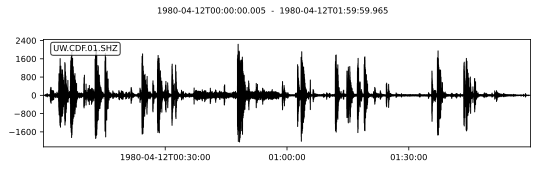

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [208]:
client = Client("IRIS")

# Collect waveforms from the datacenter
stream = client.get_waveforms(
    network="UW",
    station="CDF",
    location="01",
    channel="SHZ",
    starttime=obspy.UTCDateTime("1980-04-12T00:00:00.000"),
    endtime=obspy.UTCDateTime("1980-04-12T02:00:00.000"),
)

stream.detrend("linear")
stream.taper(0.05, type='hann')
stream.merge(fill_value=0)

stream.filter(type="highpass", freq=1.0)
stream.resample(50)
stream.plot(rasterized=True);

stream.write("../example/scattering_stream.mseed", format="MSEED")

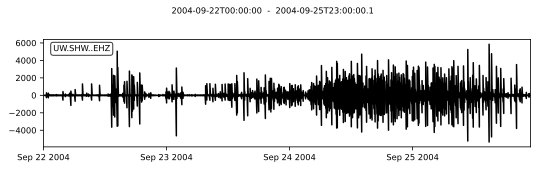

/home/jupyter_share/miniconda3/envs/seismo/lib/python3.8/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [265]:
client = Client("IRIS")

# Collect waveforms from the datacenter
stream = client.get_waveforms(
    network="UW",
    station="SHW",
    location="*",
    channel="EHZ",
    starttime=obspy.UTCDateTime("2004-09-22T00:00"),
    endtime=obspy.UTCDateTime("2004-09-25T23:00.1"),
)

stream.detrend("linear")
stream.taper(0.05, type='hann')
stream.merge(fill_value=0)

stream.filter(type="highpass", freq=1.0)
stream.resample(100)
stream.plot(rasterized=True);

stream.write("../example/scattering_stream.mseed", format="MSEED")

In [266]:
segment_duration_seconds = 20.0
sampling_rate_hertz = stream[0].stats.sampling_rate
samples_per_segment = int(segment_duration_seconds * sampling_rate_hertz)
# the network will have 2 layers
bank_keyword_arguments = (
    {"octaves": 4, "resolution": 4, "quality": 1},
    {"octaves": 5, "resolution": 2, "quality": 3},
)

### Create scatnet

In the several papers on the topic, the authors have used the Gabor wavelet. In the packaged python script, they only offer the Morlet wavelet. We will try that out!

In [267]:
network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sampling_rate_hertz,
)

print(network)

ScatteringNetwork(bins=2000, sampling_rate=100.0, len=2)
ComplexMorletBank(bins=2000, octaves=4, resolution=4, quality=1, sampling_rate=100.0, len=16)
ComplexMorletBank(bins=2000, octaves=5, resolution=2, quality=3, sampling_rate=100.0, len=10)


In [268]:
dirpath_save = "../example"

# Create directory to save the results
os.makedirs(dirpath_save, exist_ok=True)

# Save the scattering network with Pickle
filepath_save = os.path.join(dirpath_save, "scattering_network.pickle")
with open(filepath_save, "wb") as file_save:
    pickle.dump(network, file_save, protocol=pickle.HIGHEST_PROTOCOL)

Visualize the filter bank

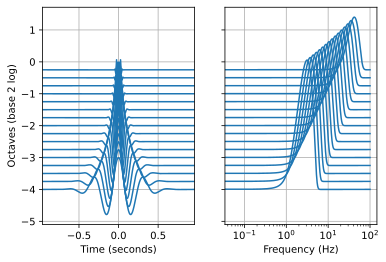

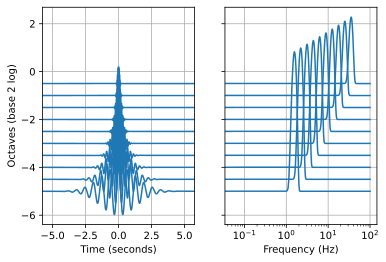

In [269]:
for bank in network.banks:

    # Create axes (left for temporal, right for spectral domain)
    fig, ax = plt.subplots(1, 2, sharey=True)

    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets, bank.spectra, bank.ratios
    ):

        # Time domain
        ax[0].plot(bank.times, wavelet.real + ratio, "C0")

        # Spectral domain (log of amplitude)
        ax[1].plot(bank.frequencies, np.log(np.abs(spectrum) + 1) + ratio, "C0")

    # Limit view to three times the temporal width of largest wavelet
    width_max = 3 * bank.widths.max()

    # Labels
    ax[0].set_ylabel("Octaves (base 2 log)")
    ax[0].set_xlabel("Time (seconds)")
    ax[0].set_xlim(-width_max, width_max)
    ax[0].grid()
    ax[1].set_xscale("log")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].grid()


Trim Seismograms

In [270]:
# Extract segment length (from any layer)
segment_duration = network.bins / network.sampling_rate
overlap = 0.5

# Gather list for timestamps and segments
timestamps = list()
segments = list()

# Collect data and timestamps
for traces in stream.slide(segment_duration, segment_duration * overlap):
    timestamps.append(mdates.num2date(traces[0].times(type="matplotlib")[0]))
    segments.append(np.array([trace.data[:-1] for trace in traces]))

### Scattering transform.
Max pooling is prone to aliasing, so use reduce_type = mean as a method to pool.

In [271]:
scattering_coefficients = network.transform(segments, reduce_type=np.mean)

In [272]:
# Save the features in a pickle file
np.savez(
    "../example/scattering_coefficients.npz",
    order_1=scattering_coefficients[0],
    order_2=scattering_coefficients[1],
    times=timestamps,
)

observe the results

/tmp/ipykernel_34103/1833550022.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(timestamps, center_frequencies, o_1.T, rasterized=True)


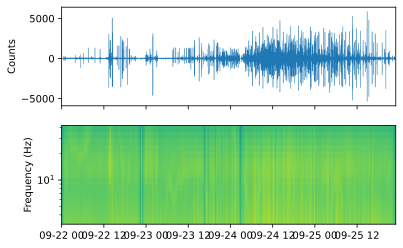

In [273]:
# Extract the first channel
channel_id = 0
trace = stream[channel_id]
o_1 = np.log10(scattering_coefficients[0][:, channel_id, :].squeeze())
center_frequencies = network.banks[0].centers

# Create figure and axes
fig, ax = plt.subplots(2, sharex=True, dpi=300)

# Plot the waveform
ax[0].plot(trace.times("matplotlib"), trace.data, rasterized=True, lw=0.5)

# First-order scattering coefficients
ax[1].pcolormesh(timestamps, center_frequencies, o_1.T, rasterized=True)

# Axes labels
ax[1].set_yscale("log")
ax[0].set_ylabel("Counts")
ax[1].set_ylabel("Frequency (Hz)")

# Show
plt.show()

In [274]:
# Load data from file
with np.load("../example/scattering_coefficients.npz", allow_pickle=True) as data:
    order_1 = data["order_1"]
    order_2 = data["order_2"]
    times = data["times"]
# Reshape and stack scattering coefficients of all orders

order_1 = order_1.reshape(order_1.shape[0], -1)
order_2 = order_2.reshape(order_2.shape[0], -1)
scattering_coefficients = np.hstack((order_1, order_2))

# transform into log
scattering_coefficients = np.log(scattering_coefficients)

# print info about shape
n_times, n_coeff = scattering_coefficients.shape
print("Collected {} samples of {} dimensions each.".format(n_times, n_coeff))


Collected 34199 samples of 176 dimensions each.


## Dimensionality reduction

This tutorial uses FastICA for the dimensionality reduction, but we can try other things

In [275]:
model_latent = FastICA(n_components=5, whiten="unit-variance", random_state=42)
features = model_latent.fit_transform(scattering_coefficients)


In [276]:
# Save the features
np.savez(
    "../example/independent_components.npz",
    features=features,
    times=times,
)

# Save the dimension reduction model
with open("../example/dimension_model.pickle", "wb") as pickle_file:
    pickle.dump(
        model_latent,
        pickle_file,
        protocol=pickle.HIGHEST_PROTOCOL,
    )

Plots the features

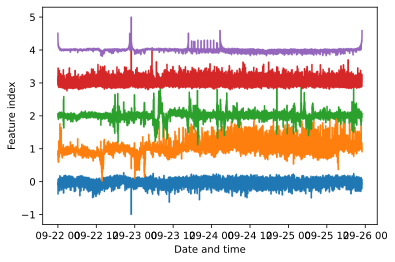

In [277]:
# Normalize features for display
features_normalized = features / np.abs(features).max(axis=0)

# Figure instance
fig = plt.figure(dpi=200)
ax = plt.axes()

# Plot features
ax.plot(times, features_normalized + np.arange(features.shape[1]), rasterized=True)

# Labels
ax.set_ylabel("Feature index")
ax.set_xlabel("Date and time")

# Show
plt.show()

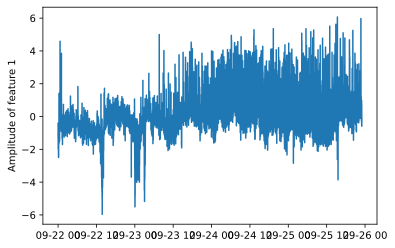

In [279]:
# Pick a feature
feature_id = 1
feature = features[:, feature_id]

# Figure creation
fig = plt.figure()
ax = plt.axes()

# Plot the weights
ax.plot(times, feature)
ax.set_ylabel(f"Amplitude of feature {feature_id}")

# Show
plt.show()

In [250]:
# ORIGINAL
# Extract weights from the dimensionality reduction model
feature_id = 1
weights = model_latent.components_[feature_id]
vmax = np.abs(weights).max()/4

# Scattering coefficients shape and frequencies
n_cha = 3
n_order_1 = network.banks[0].octaves * network.banks[0].resolution
n_order_2 = network.banks[1].octaves * network.banks[1].resolution
f_1 = network.banks[0].centers
f_2 = network.banks[1].centers

# Extract and reshape weights
order_1 = weights[: n_cha * n_order_1].reshape(n_cha, n_order_1)
order_2 = weights[n_cha * n_order_1 :].reshape(n_cha, n_order_1, n_order_2)

# Show weights
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=True, sharey="row")
image_kw = dict(vmin=-vmax, vmax=vmax, rasterized=True, cmap="PuOr")
for id, channel in enumerate("BHZ"):

    # Show
    ax[0, id].plot(f_1, order_1[id], label=channel)
    mappable = ax[1, id].pcolormesh(f_1, f_2, order_2[id].T, **image_kw)

    # Labels
    ax[0, id].set_title(channel)
    ax[1, id].set_xlabel("$f_1$ (Hz)")

# Labels
ax[0, 0].set_ylabel("Unmixing weights")
ax[1, 0].set_ylabel("$f_2$ (Hz)")
ax[1, 0].set_xscale("log")
ax[1, 0].set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="horizontal", ax=ax, shrink=0.3)
colorbar.set_label("Unmixing weights")

# Show
plt.show()

ValueError: cannot reshape array of size 128 into shape (3,16,10)

/tmp/ipykernel_34103/4045906445.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax[1].pcolormesh(f_1, f_2, order_2[0].T, **image_kw)


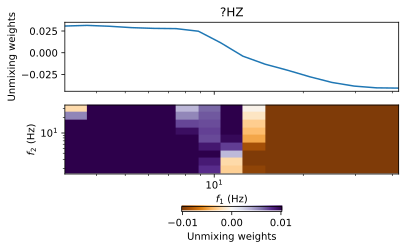

In [280]:
# ONE channel
# Extract weights from the dimensionality reduction model
feature_id = 1
weights = model_latent.components_[feature_id]
vmax = np.abs(weights).max()/4

# Scattering coefficients shape and frequencies
n_cha = 1
n_order_1 = network.banks[0].octaves * network.banks[0].resolution
n_order_2 = network.banks[1].octaves * network.banks[1].resolution
f_1 = network.banks[0].centers
f_2 = network.banks[1].centers

# Extract and reshape weights
order_1 = weights[: n_cha * n_order_1].reshape(n_cha, n_order_1)
order_2 = weights[n_cha * n_order_1 :].reshape(n_cha, n_order_1, n_order_2)

# Show weights
fig, ax = plt.subplots(nrows=2, ncols=n_cha, sharex=True, sharey="row")
image_kw = dict(vmin=-vmax, vmax=vmax, rasterized=True, cmap="PuOr")
channel = "?HZ"

# Show
ax[0].plot(f_1, order_1[0], label=channel)
mappable = ax[1].pcolormesh(f_1, f_2, order_2[0].T, **image_kw)

# Labels
ax[0].set_title(channel)
ax[1].set_xlabel("$f_1$ (Hz)")

# Labels
ax[0].set_ylabel("Unmixing weights")
ax[1].set_ylabel("$f_2$ (Hz)")
ax[1].set_xscale("log")
ax[1].set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="horizontal", ax=ax, shrink=0.3)
colorbar.set_label("Unmixing weights")

# Show
plt.show()

Reconstruction

We here reconstruct the scattering coefficients from a selected independent components. We only show the first order coefficients, since the second order coefficients are hard to map as a function of time

/tmp/ipykernel_34103/104224525.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax[id].pcolormesh(times, f_1, data, rasterized=True, vmin=vmin, vmax=vmax)


IndexError: index 1 is out of bounds for axis 1 with size 1

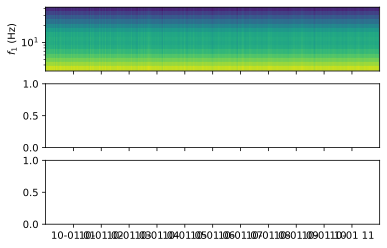

In [178]:
# ORIGINAL
# Filter out latent space
features_filtered = np.zeros(features.shape)
features_filtered[:, feature_id] = feature

# Extract all scattering coefficients
reconstructed = model_latent.inverse_transform(features_filtered)
reconstructed_order_1 = reconstructed[:, : n_cha * n_order_1].reshape(-1, n_cha, n_order_1)
vmin = reconstructed_order_1.min()
vmax = reconstructed_order_1.max()

# Plot
fig, ax = plt.subplots(nrows=3, sharex=True, sharey="row")

# Plot
for id, channel in enumerate("BHZ"):
    data = reconstructed_order_1[:, id, :].squeeze().T
    mappable = ax[id].pcolormesh(times, f_1, data, rasterized=True, vmin=vmin, vmax=vmax)
    ax[id].set_ylabel("$f_1$ (Hz)")
    ax[id].set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="vertical", ax=ax, shrink=0.5)
colorbar.set_label("Scattering coefficients")

/tmp/ipykernel_34103/401240546.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  mappable = ax.pcolormesh(times, f_1, data, rasterized=True, vmin=vmin, vmax=vmax)


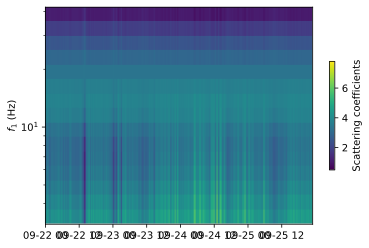

In [281]:
# Filter out latent space
features_filtered = np.zeros(features.shape)
features_filtered[:, feature_id] = feature

# Extract all scattering coefficients
reconstructed = model_latent.inverse_transform(features_filtered)
reconstructed_order_1 = reconstructed[:, : n_cha * n_order_1].reshape(-1, n_cha, n_order_1)
vmin = reconstructed_order_1.min()
vmax = reconstructed_order_1.max()

# Plot
fig, ax = plt.subplots(nrows=n_cha, sharex=True, sharey="row")

# Plot
channel = "?HZ"
data = reconstructed_order_1[:, 0, :].squeeze().T
mappable = ax.pcolormesh(times, f_1, data, rasterized=True, vmin=vmin, vmax=vmax)
ax.set_ylabel("$f_1$ (Hz)")
ax.set_yscale("log")

# Colorbar
colorbar = fig.colorbar(mappable, orientation="vertical", ax=ax, shrink=0.5)
colorbar.set_label("Scattering coefficients")

## Clustering

We will use Kmeans here. Reload the models to make things fresh

In [282]:
from sklearn.cluster import KMeans

In [283]:
# Load features and datetimes from file
with np.load("../example/independent_components.npz", allow_pickle=True) as data:
    features = data["features"]
    times = data["times"]

# Load network
network = pickle.load(open("../example/scattering_network.pickle", "rb"))

In [284]:
N_CLUSTERS = 15

# Perform clustering
model_cluster = KMeans(n_clusters=N_CLUSTERS, n_init=1, random_state=4)
model_cluster.fit(features)

# Predict cluster for each sample
predictions = model_cluster.predict(features)

Vizualize cluster-wise detection rate

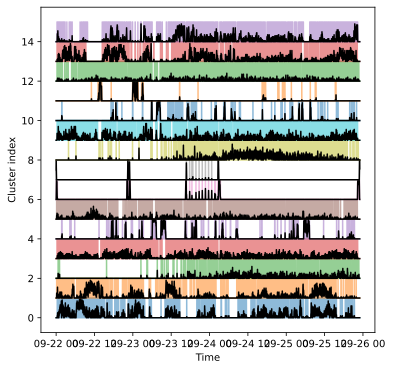

In [285]:
SMOOTH_KERNEL = 20

# Convert predictions to one-hot encoding
one_hot = np.zeros((len(times), N_CLUSTERS + 1))
one_hot[np.arange(len(times)), predictions] = 1

# Plot the results
fig, ax = plt.subplots(figsize=(6, 6))

# Plot each cluster as a separate line
for i in range(N_CLUSTERS):

    # Obtain the detection rate by convolving with a boxcar kernel
    detection_rate = np.convolve(one_hot[:, i], np.ones(SMOOTH_KERNEL), mode="same") / SMOOTH_KERNEL

    # Plot the detection rate
    ax.plot(times, one_hot[:, i] + i, alpha=0.5)
    ax.plot(times, detection_rate + i, color="black")

# Labels
ax.set_xlabel("Time")
ax.set_ylabel("Cluster index")

plt.show()

Get cluster coordinates in the feature space

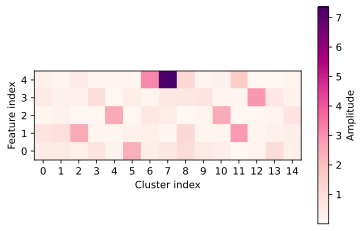

In [286]:
centroids = np.abs(model_cluster.cluster_centers_)

# Plot the centroids
fig = plt.figure()
ax = plt.axes()

# Show the centroids as a heatmap
mappable = ax.matshow(centroids.T, cmap="RdPu")

# Labels
plt.colorbar(mappable).set_label("Amplitude")
ax.set_xlabel("Cluster index")
ax.set_ylabel("Feature index")

# Ticks below
ax.xaxis.set_ticks_position("bottom")
ax.set_xticks(np.arange(N_CLUSTERS))
ax.set_yticks(np.arange(centroids.shape[1]))
ax.invert_yaxis()

# Show
plt.show()

Now display the waveforms that we clustered in each group

In [287]:
N_WAVEFORMS = 5

# Read the stream
stream = obspy.read("../example/scattering_stream.mseed").select(channel="?HZ")
waveform_duration = network.bins / network.sampling_rate

# Extract waveforms
waveforms = list()
for cluster in np.unique(predictions):

    # Calculate the distance of each sample to the cluster mean
    mean = np.mean(features[predictions == cluster], axis=0)
    distance = np.linalg.norm(features[predictions == cluster] - mean, axis=1)
    closest = times[predictions == cluster][distance.argsort()[:5]]

    # Collect closest waveforms in a list
    traces = list()
    for time in closest[:N_WAVEFORMS]:
        time = obspy.UTCDateTime(time)
        trace = stream.slice(time, time + waveform_duration)[0].copy()
        traces.append(trace)
    waveforms.append(traces)

Now plot the waveforms

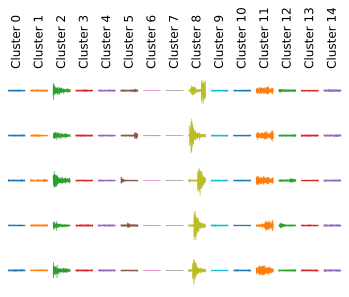

In [288]:
# Plot the results
fig, ax = plt.subplots(N_WAVEFORMS, N_CLUSTERS, sharex=True, sharey=True, dpi=300)

# Plot each cluster as a separate line
for i, traces in enumerate(waveforms):
    ax[0, i].set_title(f"Cluster {i}", rotation="vertical")
    for j, trace in enumerate(traces):
        ax[j, i].plot(trace.times(), trace.data, rasterized=True, lw=0.6, color=f"C{i}")
        ax[j, i].set_axis_off()

# Show
plt.show()

In this tutorial, we failed at detecting the onset of the landslides. We can repeat the analysis by playing with the following parameters:
* number of clusters
* numbers of ICAs
* the original data
* the clustering algorithm, you may choose agglomerative clustering
* Depth of the scattering network. Someone could help in creating a class with Gabor wavelets.